# 深层前馈神经网络

构建一个L-层的前馈神经网络用于解决分类问题，在隐藏层使用Relu激活函数，在输出层使用Sigmoid激活函数，我们使用下面的步骤进行实现：
1. 初始化参数 Initialise Parameters
2. 前向传播 Forward Propagation
3. 计算损失 Compute Cost
4. 反向传播 Backward Propagation
5. 更新参数 Update Parameters
6. 预测 Predict
7. 评估 Assessment

## 导入库 Packages

1. numpy 用于科学计算
2. matplotlib 用于数据可视化
3. h5py 用于处理h5格式的数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

## 初始化参数 Initialise Parameters
<p>第$l$层的整体权重为$W^{[l]}$，每层中矩阵$W$的形状取决于上一层中输出$A$（或$X$）的形状以及当前层中神经元的个数，形状为(当前层数, 上一层数)，数值可以随机初始化，然后通过反向传播得到最终的值。</p>
<p>第$l$层的整体偏置为$b^{[l]}$，每层中矩阵$b$的形状取决于当前层中神经元的个数，形状为(当前层数, 1)，数值一般初始为0，然后通过反向传播得到最终的值。</p>

In [3]:
# 初始化参数函数，输入神经网络的层数、神经元信息，输出初始化后的权重和偏置
def initialise_parameters(layer_dims): # layer_dims = [输入层特征数，第一层神经元数，第二层神经元特征数...，输出层特征数]，表现每层有多少神经元
    L = len(layer_dims) # 计算神经网络一共多少层
    parameters = {} # 创建参数字典，存储各参数的值

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l] , layer_dims[l-1]) * 0.01 # 计算各层权重的值并存储在parameters中
        parameters["b" + str(l)] = np.random.randn(layer_dims[l], 1) # 计算各层偏置的值并存储在parameters中
    return parameters

## 前向传播 Forward Propagation
<p>在得到初始化的参数后，通过输入值进行前向传播过程计算出预测值，输入值$X$的形状为(特征数，样本数)。</p>
<p>隐藏层全部使用Relu激活函数，输出层使用Sigmoid激活函数</p>
<p>在隐藏层中时，<br/> $Z^{[l]}=W^{[1]} A^{[l-1]}+b^{[1]}(输入层的X即为A^{[0]})\\ A^{[1]}=\operatorname{Relu}\left(Z^{[1]}\right)$</p>
<p>在输出层中时，<br/> $Z^{[L]}=W^{[L]} A^{[L-1]}+b^{[L]}\\ A^{[L]}=\sigma(Z^{[L]})$</p>

In [18]:
def sigmoid(Z):   
    A = 1/(1+np.exp(-Z))  
    return A

def relu(Z):
    
    A = np.maximum(0,Z)
    
    return A

# 前向传播函数。输入训练数据X和参数W、b，计算后输出预测值以及中间产生的输出，以用于反向传播
def forward_propagation(X, parameters):
    caches = {} # 数组caches，存储前向传播过程中产生的中间输出
    L = len(parameters) // 2 # 因为parameters里包括隐藏层和输出层的W和b，长度除以二就能得到神经网络层数
    caches["A0"] = X # 先存入输入的数据X
    for l in range(1, L):
        A = caches["A" + str(l - 1)] 
        caches["Z" + str(l)] = np.dot(parameters["W"+str(l)], A) + parameters["b"+str(l)] # 计算进入下一层时线性函数的结果Z并存储
        caches["A" + str(l)] = np.maximum(caches["Z" + str(l)], 0) # 计算上一层的输出A并存储
        #print(caches["A" + str(l)].shape)
    ZL = np.dot(parameters["W"+str(L)], caches["A" + str(L-1)]) + parameters["b"+str(L)]
    Y_hat = sigmoid(ZL) # 得到输出层的数据，也就是预测值
    return Y_hat, caches

## 计算损失 Compute Cost

根据最大似然估计，$J = -\frac{1}{m} \sum_{i=1}^{m}\left(y^{(i)} \log \left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{y}^{(i)}\right)\right)$

In [19]:
def compute_cost(Y, Y_hat):
    m = Y.shape[1] # 计算总样本数
    cost = - 1 / m * (np.dot(np.log(Y_hat), Y.T) + np.dot(np.log(1-Y_hat), (1-Y).T)) # 计算损失
    cost = np.squeeze(cost) # 确保损失为一维形状
    return cost

## 反向传播 Backward Propagation

在隐藏层中： 

$dW^{[l]}=np.dot(dZ^{[l]},A^{[l-1]}.T)/m$

$db^{[l]} = np.sum(dZ^{[l]},axis=1)/m$

$dA^{[l-1]} = np.dot(dW^{[l]}.T, dZ^{[l]})$

$dZ^{[l-1]} = dA^{[l-1]}*ReLu\_backward(Z^{[l-1]})$

在输出层中：

$dZ^{[L]}=Y\_hat - Y$a

In [4]:
def sigmoid_backward(dA, Z): 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [5]:
def relu_backward(dA, Z): 
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [6]:
def backward_propagation(Y_hat, Y, caches, parameters):
    m = Y_hat.shape[1] # 神经网络层数
    L = len(parameters) // 2
    grads = {} # 存储中间产生的梯度的字典
    grads["dZ"+str(L)] = Y_hat - Y # 先存储关于输出层中Z的梯度
    #print( grads["dZ"+str(L)].shape)
    for l in range(L, 0,-1):

        grads["dW" + str(l)] = 1/m * np.dot(grads["dZ"+str(l)], caches["A"+str(l-1)].T)
        grads["db" + str(l)] = 1/m *  np.sum(grads["dZ"+str(l)], axis=1, keepdims=True)

        if l > 1:
            grads["dA" + str(l-1)] = np.dot(parameters["W"+str(l)].T, grads["dZ"+str(l)])
            grads["dZ"+str(l-1)] =  relu_backward(grads["dA" + str(l-1)], caches["Z"+str(l-1)] )
    return grads

##  更新参数 Update Parameters

$W=W-\alpha \frac{\partial L(y,\hat{y})}{\partial W}$

$b=b-\alpha \frac{\partial L(y,\hat{y})}{\partial b}$

In [7]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # 神经网络的总层数
    for l in range(1, L + 1):
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * grads["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * grads["db"+str(l)]

    return parameters

## 模型架构

In [21]:
def dnn_model(X, Y, layer_dims, iterations, learning_rate):
    parameters = initialise_parameters(layer_dims) # 初始化参数
    np.random.seed(1)
    costs = []
    for i in range(iterations):
        Y_hat, caches = forward_propagation(X, parameters) # 前向传播
        cost = compute_cost(Y, Y_hat) # 计算损失
        if i % 100 == 0: # 每训练100次，打印一次当前的损失值
            print("第", i, "次迭代的损失：", cost)
            costs.append(cost) # 将每百次的损失值存入数组，方便最后画图
        grads = backward_propagation(Y_hat, Y, caches, parameters) # 反向传播
        parameters = update_parameters(parameters, grads, learning_rate) # 更新参数
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations(per 100)')
    return parameters

## 导入数据集

数据集是Cat-NonCat，包含200多张图片，有的图片包含猫，有的图片不包含猫。<br/><br/>
任务是训练一个深度学习模型，能够通过分辨出图片中是否包含猫。

In [11]:
def load_data():
    # 数据下载在本地，根据存储位置修改参数
    train_dataset = h5py.File('train_catvnoncat.h5', "r") # 训练集
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 训练集中的特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 训练集中的标签
    test_dataset = h5py.File('test_catvnoncat.h5', "r") # 测试集
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 测试集的特征 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 测试集的标签
    
    # 原来的数据集中标签y的形状为（样本数，标签），根据我们的算法需要改为（标签，样本数）
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [12]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

### 查看数据集的矩阵形状

In [13]:
print("训练集的未处理特征形状为：", train_x_orig.shape)
print("训练集的标签形状为：", train_y.shape)
print("测试集的未处理特征形状为：", test_x_orig.shape)
print("测试集的标签形状为：", test_y.shape)

训练集的未处理特征形状为： (209, 64, 64, 3)
训练集的标签形状为： (1, 209)
测试集的未处理特征形状为： (50, 64, 64, 3)
测试集的标签形状为： (1, 50)


### 随机显示训练集中的5张图像

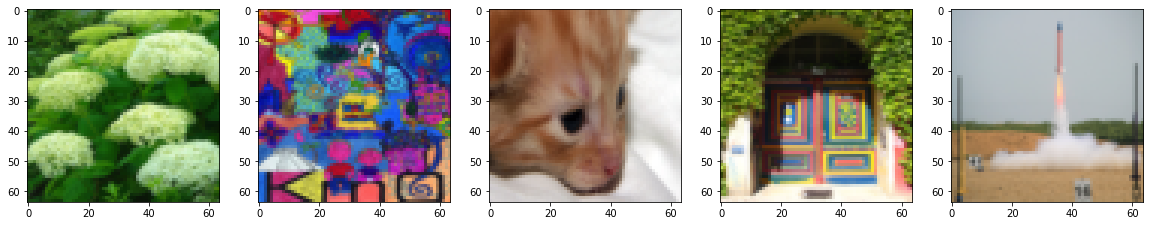

In [14]:
plt.figure(figsize=(20,10)) # 设置图片的大小
indexes = np.random.randint(209, size = 5) # 随机5个0-209间的整数
for i in range(len(indexes)):
    ax1=plt.subplot(1,5,i+1) # 设置图片的位置
    plt.imshow(train_x_orig[indexes[i]]) # 展示图片

### 特征处理
因为目前的特征是(像素长X像素宽X三通道)的形状，所以需要将它们压缩到一个维度

In [15]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# 将特征值缩放，小的值训练比较快
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
print("训练集的特征形状为：", train_x.shape)
print("测试集的特征形状为：", test_x.shape)

训练集的特征形状为： (12288, 209)
测试集的特征形状为： (12288, 50)


### 使用深度学习模型

In [16]:
#定义超参数

layers_dims = [12288, 5, 1] # 两层神经网络，其中输入层有12288个特征，隐藏层有5个神经元，输出层有1个神经元
iterations = 2000 # 迭代次数
learning_rate = 0.02 # 学习速率

第 0 次迭代的损失： 0.8934465402884945
第 100 次迭代的损失： 0.5546904199438063
第 200 次迭代的损失： 0.4882796880621495
第 300 次迭代的损失： 0.4937431099815252
第 400 次迭代的损失： 0.47638165554563533
第 500 次迭代的损失： 0.3706672999644307
第 600 次迭代的损失： 0.2503760200007266
第 700 次迭代的损失： 0.19556218643422935
第 800 次迭代的损失： 0.13573576910712215
第 900 次迭代的损失： 0.10071366016959771
第 1000 次迭代的损失： 0.08064871573432077
第 1100 次迭代的损失： 0.06359895785087907
第 1200 次迭代的损失： 0.04553648889888596
第 1300 次迭代的损失： 0.035514422923239225
第 1400 次迭代的损失： 0.028320268246417934
第 1500 次迭代的损失： 0.02320768636362626
第 1600 次迭代的损失： 0.019406671174879188
第 1700 次迭代的损失： 0.01632039271161368
第 1800 次迭代的损失： 0.014041165600788896
第 1900 次迭代的损失： 0.012230253713456181


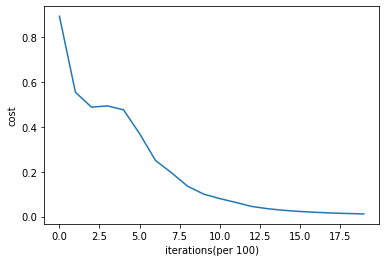

In [22]:
# 调用模型开始训练
parameters_1 = dnn_model(train_x, train_y, layers_dims, iterations, learning_rate) 

## 预测
有了训练好的参数后，使用前向传播计算预测值

In [23]:
def predict(parameters, X):
    # 传入训练好的参数以及测试集的特征
    Y_hat,caches = forward_propagation(X, parameters) # 前向传播以得到预测值Y_hat
    predictions =  Y_hat  > 0.5 # 如果预测概率大于0.5输出1（狗），否则输出0（猫）
    return predictions #返回预测值
    return p

In [24]:
predictions = predict(parameters_1,train_x)

In [25]:
predictions

array([[False, False,  True, False, False, False, False,  True, False,
        False, False,  True, False,  True,  True, False, False, False,
        False,  True, False, False, False, False,  True,  True, False,
         True, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False,  True,  True, False, False,
        False, False,  True, False, False,  True, False, False, False,
         True, False,  True,  True, False,  True,  True,  True, False,
        False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False,  True,  True, False, False, False,  True, False,
        False, False,  True,  True,  True, False, False,  True, False,
        False, False, False,  True, False,  True, False,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
         True, False, False, False,  True, False, False,  True, False,
      

## 评估
可以使用各种方法来对模型进行评估，这里使用最基础的精度（accuracy）

In [26]:
def compute_accuracy(Y_hat, Y):
    accuracy = (np.dot(Y, Y_hat.T) + np.dot(1 - Y, (1 - Y_hat).T)) / float(Y.size) * 100
    accuracy = float(accuracy)
    return accuracy

In [27]:
train_accuracy = compute_accuracy(predictions, train_y)
train_accuracy

100.0

In [29]:
predictions_test= predict(parameters_1,test_x)
test_accuracy = compute_accuracy(predictions_test,test_y)
test_accuracy

68.0

可以看到，模型在训练集上有100%的准确率，在测试集上有68%的准确率

## 模型调整与比较
我们可以尝试调整超参数来提高模型的表现，比如神经网络结构、迭代次数、学习速率等

第 0 次迭代的损失： 0.6750274352095188
第 100 次迭代的损失： 0.6465785804163852
第 200 次迭代的损失： 0.6441361350887488
第 300 次迭代的损失： 0.6439801991781229
第 400 次迭代的损失： 0.6439707655071479
第 500 次迭代的损失： 0.6439695842547007
第 600 次迭代的损失： 0.6439688101747866
第 700 次迭代的损失： 0.643968007633608
第 800 次迭代的损失： 0.6439671541193095
第 900 次迭代的损失： 0.6439662853341772
第 1000 次迭代的损失： 0.6439653630286272
第 1100 次迭代的损失： 0.6439643606774043
第 1200 次迭代的损失： 0.6439632821064526
第 1300 次迭代的损失： 0.643962225009414
第 1400 次迭代的损失： 0.6439611816797282
第 1500 次迭代的损失： 0.6439600775988411
第 1600 次迭代的损失： 0.6439589242150445
第 1700 次迭代的损失： 0.643957694306966
第 1800 次迭代的损失： 0.6439563689588523
第 1900 次迭代的损失： 0.6439549375271689
在训练集上的精度为： 65.55023923444976
在测试集上的精度为： 34.0


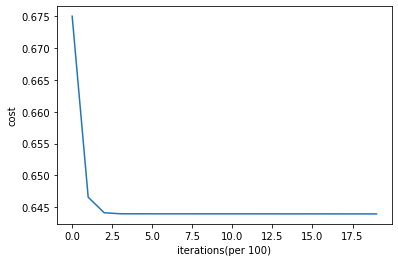

In [31]:
# 使用一个5层的神经网络结构，迭代次数和学习速率不变

layers_dims = [12288, 7, 5, 3, 1] 
iterations = 2000 # 迭代次数
learning_rate = 0.02 # 学习速率

parameters_five_layers = dnn_model(train_x, train_y, layers_dims, iterations, learning_rate) 
predictions_train_five_layers = predict(parameters_five_layers,train_x)
predictions_test_five_layers = predict(parameters_five_layers,test_x)
train_accuracy_five_layers = compute_accuracy(predictions_train_five_layers, train_y)
test_accuracy_five_layers = compute_accuracy(predictions_test_five_layers,test_y)
print("在训练集上的精度为：", train_accuracy_five_layers)
print("在测试集上的精度为：", test_accuracy_five_layers)

第 0 次迭代的损失： 0.9295152275257489
第 100 次迭代的损失： 0.7204532903553311
第 200 次迭代的损失： 0.6484693856777068
第 300 次迭代的损失： 0.6375639482446427
第 400 次迭代的损失： 0.6184262519890674
第 500 次迭代的损失： 0.5840124433969683
第 600 次迭代的损失： 0.5365820076105702
第 700 次迭代的损失： 0.48544838737491935
第 800 次迭代的损失： 0.45259667459985753
第 900 次迭代的损失： 0.43336124339434234
第 1000 次迭代的损失： 0.3914822803159087
第 1100 次迭代的损失： 0.366430672564859
第 1200 次迭代的损失： 0.33773385962591357
第 1300 次迭代的损失： 0.31788360579443053
第 1400 次迭代的损失： 0.3486115372000598
第 1500 次迭代的损失： 0.29782657019359915
第 1600 次迭代的损失： 0.21692889924257266
第 1700 次迭代的损失： 0.18179976939414302
第 1800 次迭代的损失： 0.15782501363913226
第 1900 次迭代的损失： 0.11569610126098998
在训练集上的精度为： 99.04306220095694
在测试集上的精度为： 74.0


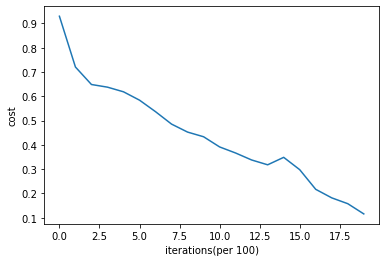

In [39]:
# 使用一个3层的神经网络结构，以及更小的学习速率，迭代次数不变

layers_dims = [12288, 5, 3, 1] 
iterations = 2000 # 迭代次数
learning_rate = 0.01 # 学习速率

parameters_five_layers = dnn_model(train_x, train_y, layers_dims, iterations, learning_rate) 
predictions_train_five_layers = predict(parameters_five_layers,train_x)
predictions_test_five_layers = predict(parameters_five_layers,test_x)
train_accuracy_five_layers = compute_accuracy(predictions_train_five_layers, train_y)
test_accuracy_five_layers = compute_accuracy(predictions_test_five_layers,test_y)
print("在训练集上的精度为：", train_accuracy_five_layers)
print("在测试集上的精度为：", test_accuracy_five_layers)